In [1]:
#general

import pandas as pd
import numpy as np
import os
import pickle
import time
import sys


import tensorflow as tf

#for utility packages
from Utilities.utilities import import_data
from Utilities.utilities import reset_graph

from functools import partial

from tan.tan_util import get_tan_nll as tan
from tan.tan_util import get_tan_nll_cond as tan_cond


#For parsing records once written
from Utilities.set_record_parser import build_set_dataset
from Utilities.set_record_parser import get_file_lists
from Utilities.models import log_dir_build

c:\users\sdgeo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Setup Directories 

Here we are going to get the files needed to do the project

In [2]:
#Locate Neccesary Files
#Get Imageanet Label and Record Location
labels_file = "D:/Machine_Learning/Datasets/ImageNet_2012/labels.txt"
tf_record_directory =  'D:/Machine_Learning/Datasets/Set_Project/Code_Class_TF_Records'

#Make 
class_file = open(labels_file,'r')
labels = class_file.read().split('\n')
class_file.close()


In [3]:
# Import location of TF_Records
train_list, val_list = get_file_lists(tf_record_directory)
train_list

['D:/Machine_Learning/Datasets/Set_Project/Code_Class_TF_Records\\Training_Set-00000-of-00002',
 'D:/Machine_Learning/Datasets/Set_Project/Code_Class_TF_Records\\Training_Set-00001-of-00002']

# Design Neural Network

The following provides the code to import and use the TF_Records for the set project

In [74]:
#directory for logs in training
set_net_logs = 'D:/AI/models/set_project/logs'
model_path = log_dir_build(set_net_logs, "set_project")

#directory for all the models saved during training
set_net_model = 'D:/AI/models/set_project/model/' + 'set_project'
set_net_model_best = 'D:/AI/models/set_project/model/' + 'set_project_best'

In [75]:
reset_graph()

#Placeholder for choosing input, epochs, batches, and datasets at runtime
number_of_classes = 100

with tf.name_scope('Data_Retrieval'):
    filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
    batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
    num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
    training = tf.placeholder_with_default(True, shape=(), name = 'training')
    handle = tf.placeholder(tf.string, shape=[], name="Dataset")
    code_size = 2048
    set_size = 3

    training_set = build_set_dataset(True, filename, code_size, set_size, batch_size, num_epochs, num_parallel_calls=8)
    validation_set = build_set_dataset(False, filename, code_size, set_size, batch_size, num_epochs, num_parallel_calls=8)

    train_iterator = training_set.make_initializable_iterator()
    val_iterator = validation_set.make_initializable_iterator()

    iterator = tf.data.Iterator.from_string_handle(
        handle, training_set.output_types, training_set.output_shapes)
    next_element = iterator.get_next()
    code_data, class_data, file_data, uniques_data = next_element

    code = tf.placeholder_with_default(code_data, [None,3,2048])
    uniques = tf.placeholder_with_default(uniques_data, [None])

with tf.name_scope("BN_Layer_AE_Layers"):
    #Define initalizer and batch normalization layers
    bn_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)
    he_init = tf.contrib.layers.variance_scaling_initializer()

with tf.name_scope("Set_Analyzer"):
    #the network for generating output of our set
    
    with tf.name_scope('Deep_Sets'):
        batch_item = tf.cast(batch_size, tf.int32)
        
        with tf.name_scope('DeepSet_Layer_1'):
            identity_matrix = tf.cast(tf.eye(3,num_columns=3, batch_shape=[batch_item]),tf.float16)
            lambda_1 = tf.get_variable("lambda_1", [1], trainable=True, dtype=tf.float16)
            sigma_1 = tf.get_variable("sigma_1", [1], trainable=True, dtype=tf.float16)
            max_pool_1 = tf.reduce_max(code)
            learned_a = lambda_1 * identity_matrix
            pre_activation_1 = tf.linalg.matmul(learned_a, code) + sigma_1 * max_pool_1
            layer_1 = tf.nn.sigmoid(pre_activation_1)
            
        with tf.name_scope('DeepSet_Layer_2'):
            lambda_2 = tf.get_variable("lambda_2", [1], trainable=True, dtype=tf.float16)
            sigma_2 = tf.get_variable("sigma_2", [1], trainable=True, dtype=tf.float16)
            max_pool_2 = tf.reduce_max(layer_1)
            learned_b = lambda_2 * identity_matrix
            pre_activation_2 = tf.linalg.matmul(learned_b, layer_1) + sigma_2 * max_pool_2
            layer_2 = tf.nn.sigmoid(pre_activation_2)
            
        with tf.name_scope('DeepSet_Layer_3'):
            lambda_3 = tf.get_variable("lambda_3", [1], trainable=True, dtype=tf.float16)
            sigma_3 = tf.get_variable("sigma_3", [1], trainable=True, dtype=tf.float16)
            max_pool_3 = tf.reduce_max(layer_2)
            learned_c = lambda_3 * identity_matrix
            pre_activation_3 = tf.linalg.matmul(learned_c, layer_2) + sigma_3 * max_pool_3
            layer_3 = tf.nn.sigmoid(pre_activation_3)

        with tf.name_scope('DeepSet_Layer_4'):
            lambda_4 = tf.get_variable("lambda_4", [1], trainable=True, dtype=tf.float16)
            sigma_4 = tf.get_variable("sigma_4", [1], trainable=True, dtype=tf.float16)
            max_pool_4 = tf.reduce_max(layer_3)
            learned_d = lambda_4 * identity_matrix
            pre_activation_4 = tf.linalg.matmul(learned_d, layer_3) + sigma_4 * max_pool_4
            layer_4 = tf.nn.sigmoid(pre_activation_4)
            
        with tf.name_scope('Final_Pool'):
            invariant_layer = tf.reduce_sum(layer_4, 1)
            
    with tf.name_scope('Dense_Layers_Classification'):
        #Set constants for Classifier
        dropout_rate = 0.2
        n_hidden1 = 1000
        n_hidden2 = 500
        n_final_layer = number_of_classes
        learning_rate_class = .1
        
        
        with tf.name_scope("Class_Hidden_Layer_1"):
            hidden1_cat = tf.layers.dense(invariant_layer, n_hidden1, name="hidden1_cat", kernel_initializer=he_init)
            hidden1_drop = tf.layers.dropout(hidden1_cat, dropout_rate, training=training)
            hidden1_cast = tf.cast(hidden1_drop, tf.float32)
            bn1_cat = bn_batch_norm_layer(hidden1_cast)
            bn1_act_cat = tf.nn.relu(bn1_cat)        
        
        with tf.name_scope("Class_Hidden_Layer_2"):
            hidden2_cat = tf.layers.dense(bn1_act_cat, n_hidden2, name="hidden2_cat", kernel_initializer=he_init)
            hidden2_drop = tf.layers.dropout(hidden2_cat, dropout_rate, training=training)
            bn2_cat = bn_batch_norm_layer(hidden2_drop)
            bn2_act_cat = tf.nn.relu(bn2_cat) 
  
        
        with tf.name_scope("Final_Layer"): 
            logits_before_bn = tf.layers.dense(bn2_act_cat, n_final_layer, name="outputs")
            logits = bn_batch_norm_layer(logits_before_bn, name="logits")
            softmax = tf.nn.softmax(logits, name="final_soft_max")

        with tf.name_scope("loss"):
                cast_class = tf.cast(class_data, tf.int32)
                one_hot = tf.one_hot(cast_class, number_of_classes)
                summed_hot = tf.reduce_sum(one_hot, axis=1)
                correct_class = tf.nn.softmax(summed_hot)
                
                loss_cat = tf.losses.softmax_cross_entropy(correct_class,softmax)
                loss_summary_cat = tf.summary.scalar('loss_summary_cat', loss_cat)
            
        with tf.name_scope("train"):
            global_step = tf.Variable(0, trainable=False, name='global_step')
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_class)

            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            deep_train = tf.get_collection(tf.GraphKeys.VARIABLES)

            with tf.control_dependencies(extra_update_ops):
                with tf.control_dependencies(deep_train):
                    training_op_class = optimizer.minimize(loss_cat, global_step=global_step)
                
    with tf.name_scope('Unique_Identify'):
        
        unique_hidden_size = 10
        
        with tf.name_scope("Unique_Hidden_Layer_1"):
            unique_hidden_1 = tf.layers.dense(bn2_act_cat, n_final_layer, name="unique_1")
            unique_hidden1_drop = tf.layers.dropout(unique_hidden_1, dropout_rate, training=training)
            unique_bn_1 = bn_batch_norm_layer(unique_hidden1_drop, name="Unique_BN_1")
            unique_bn_1_act = tf.nn.relu(unique_bn_1)
            
        with tf.name_scope("Unique_Hidden_Layer_2"):
            unique_hidden_2 = tf.layers.dense(unique_bn_1_act, unique_hidden_size , name="unique_2")
            unique_hidden2_drop = tf.layers.dropout(unique_hidden_2, dropout_rate, training=training)
            unique_bn_2 = bn_batch_norm_layer(unique_hidden2_drop, name="Unique_BN_2")
            unique_bn_2_act = tf.nn.relu(unique_bn_2)
            
        with tf.name_scope("Final_Prediction"):
            unique_final = tf.layers.dense(unique_bn_2_act, 1 , name="unique_final", activation=tf.nn.relu)
            
        with tf.name_scope("Unique_loss"):
                correct_unique = tf.cast(tf.expand_dims(uniques, axis=0), tf.int32)
                loss_unq = tf.losses.mean_squared_error(correct_unique,unique_final)
                loss_summary_unq = tf.summary.scalar('loss_summary_unq', loss_unq)
                
        with tf.name_scope("unique_train"):
            global_step_unique = tf.Variable(0, trainable=False, name='global_step_unique')
            optimizer_unq = tf.train.AdamOptimizer(learning_rate=learning_rate_class)

            extra_update_ops_unq = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            with tf.control_dependencies(extra_update_ops_unq):
                with tf.control_dependencies(deep_train):
                    training_op_unq = optimizer_unq.minimize(loss_unq, global_step=global_step_unique)
            

init = tf.global_variables_initializer()    
saver_total = tf.train.Saver(name="Full_Graph")

In [76]:
#Write Graph to log directory
filewriter = tf.summary.FileWriter(model_path, tf.get_default_graph())

In [77]:
#Initialize the network
with tf.Session() as sess:
    init.run()
    saver_total.save(sess, set_net_model)
    saver_total.save(sess, set_net_model_best)
    

# Train the Network

Train the network to both generate conditioning for the network and also classify the type of set

In [ ]:
epochs = 200
steps_between_test_save = 1
batch = 30
train_size = 64000
all_data_steps = np.int(np.floor(train_size/batch))
lowest_loss = 10000


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    saver_total.restore(sess, set_net_model)
    
    #Set up the global steps
    step = 1
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #initialize iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())
    
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):

            #run Training Op
            sess.run([training_op_class, training_op_unq], feed_dict={handle: train_handle, batch_size: batch})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0) :
            loss_sum, loss_val, loss_un, loss_un_val = sess.run([loss_summary_cat, loss_cat, loss_summary_unq, loss_unq], 
                                                   feed_dict = {handle: val_handle ,training: False, batch_size: batch})
            filewriter.add_summary(loss_sum, step)
            filewriter.add_summary(loss_un, step)
            print("Epoch: " + str(step) + " Class Loss: " + str(loss_val) + " Unique Loss: " + str(loss_un_val))
            if lowest_loss > loss_val:
                saver_total.save(sess, set_net_model_best)
                lowest_loss = loss_val
            saver_total.save(sess, set_net_model)
        step = step + 1
            
    #Finish the final Model
    saver_total.save(sess, set_net_model)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")

INFO:tensorflow:Restoring parameters from D:/AI/models/set_project/model/set_project
Loaded model. Training network initially. Logs into: D:/AI/models/set_project/logs/set_project-run-20190219215535/


# Test the Training

Here we will see how the network performs after training

# Network Demonstration

Here we are going to show running the bones of the network and look a the training data 

In [20]:
with tf.Session() as sess:
    #Initialize Train and validation iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: 1, num_epochs:1})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: 1, num_epochs:1})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())

    test_code, test_class, test_file, test_unique = sess.run([code, class_data, file_data, uniques], feed_dict={handle: val_handle,training: False})

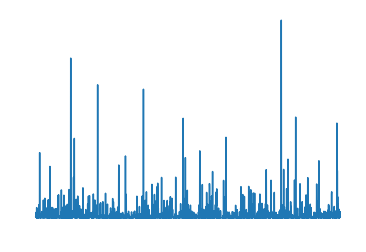

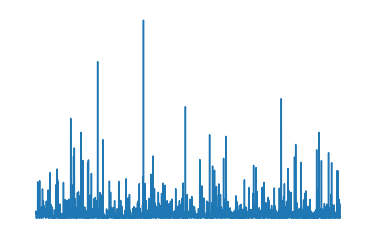

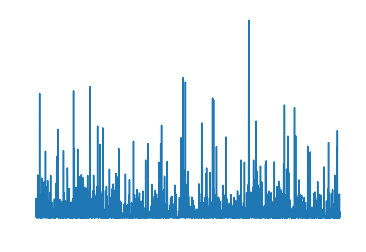

In [21]:
#Show codes from single example
for i in range(0,3):
    X_test = test_code[0][i]
    x_val = X_test

    from matplotlib import pyplot as plt
    plt.plot(x_val)
    plt.axis('off')
    plt.show()

In [22]:
#Show class for each item in set
for i in range(0,3):
    X_test = test_class[0][i]
    print('Class: ' + str(X_test) + ' Label: ' + labels[X_test])

Class: 70 Label: West_Highland_white_terrier
Class: 70 Label: West_Highland_white_terrier
Class: 70 Label: West_Highland_white_terrier


In [23]:
#Show what images the codes came from
print(test_file)

[b'ILSVRC2012_val_00045035.JPEG,ILSVRC2012_val_00041157.JPEG,ILSVRC2012_val_00028945.JPEG,']


In [24]:
#Show how many unitque Items are in the set
test_unique[0]

1